In [22]:
import matplotlib.pyplot as plt
import numpy as np
import timeit

import gt4py
from gt4py import gtscript

iterations = np.arange(1,6)

In [24]:
@gtscript.stencil(backend="gtx86")
def diffusion_stencil_x86(in_storage: gtscript.Field[float], out_storage: gtscript.Field[float]):
    with computation(PARALLEL), interval(...):
        alpha = 1.0 / 32.0
        tmp_storage = (
            -4.0 * in_storage[0, 0, 0]
            + in_storage[1, 0, 0]
            + in_storage[-1, 0, 0]
            + in_storage[0, 1, 0]
            + in_storage[0, -1, 0]
        )
        out_storage = (
            -4.0 * tmp_storage[0, 0, 0]
            + tmp_storage[1, 0, 0]
            + tmp_storage[-1, 0, 0]
            + tmp_storage[0, 1, 0]
            + tmp_storage[0, -1, 0]
        )
        out_storage = in_storage[0, 0, 0] - alpha * out_storage[0, 0, 0]
        in_storage = out_storage

In [35]:
def run_gtx86_experiment(size):
    gtx86_values = np.zeros(5)
    nx = 100 * size
    halo = 3
    shape = (nx + 2 * halo, nx + 2 * halo, 1)
    in_storage_x86 = gt4py.storage.ones(
        shape=shape,
        default_origin=(0, 0, 0),
        dtype=float,
        backend="gtx86",
    )
    in_storage_x86.data[halo + nx // 3 : halo + 2 * nx // 3, halo + nx // 3 : halo + 2 * nx // 3, :] = 1
    out_storage_x86 = gt4py.storage.zeros(
        shape=shape,
        default_origin=(0, 0, 0),
        dtype=float,
        backend="gtx86",
    )
    tic = timeit.default_timer()
    for i in range(500):
        diffusion_stencil_x86(in_storage_x86, out_storage_x86, origin=(halo, halo, 0), domain=(nx, nx, 1))
    toc = timeit.default_timer()
    return toc - tic

In [36]:
gtx86_values = np.zeros(5)
for j in range(5):
    gtx86_values[j] = run_gtx86_experiment(iterations[j])

In [37]:
@gtscript.stencil(backend="gtcuda")
def diffusion_stencil_cuda(in_storage: gtscript.Field[float], out_storage: gtscript.Field[float]):
    with computation(PARALLEL), interval(...):
        alpha = 1.0 / 32.0
        tmp_storage = (
            -4.0 * in_storage[0, 0, 0]
            + in_storage[1, 0, 0]
            + in_storage[-1, 0, 0]
            + in_storage[0, 1, 0]
            + in_storage[0, -1, 0]
        )
        out_storage = (
            -4.0 * tmp_storage[0, 0, 0]
            + tmp_storage[1, 0, 0]
            + tmp_storage[-1, 0, 0]
            + tmp_storage[0, 1, 0]
            + tmp_storage[0, -1, 0]
        )
        out_storage = in_storage[0, 0, 0] - alpha * out_storage[0, 0, 0]
        in_storage = out_storage

In [38]:
def run_gtcuda_experiment(size):
    gtcuda_values = np.zeros(5)
    nx = 100 * size
    halo = 3
    shape = (nx + 2 * halo, nx + 2 * halo, 1)
    in_storage_cuda = gt4py.storage.ones(
        shape=shape,
        default_origin=(0, 0, 0),
        dtype=float,
        backend="gtcuda",
    )
    in_storage_cuda.data[halo + nx // 3 : halo + 2 * nx // 3, halo + nx // 3 : halo + 2 * nx // 3, :] = 1
    out_storage_cuda = gt4py.storage.zeros(
        shape=shape,
        default_origin=(0, 0, 0),
        dtype=float,
        backend="gtcuda",
    )
    tic = timeit.default_timer()
    for i in range(500):
        diffusion_stencil_cuda(in_storage_cuda, out_storage_cuda, origin=(halo, halo, 0), domain=(nx, nx, 1))
    toc = timeit.default_timer()
    return toc - tic

In [39]:
gtcuda_values = np.zeros(5)
for j in range(5):
    gtcuda_values[j] = run_gtcuda_experiment(iterations[j])

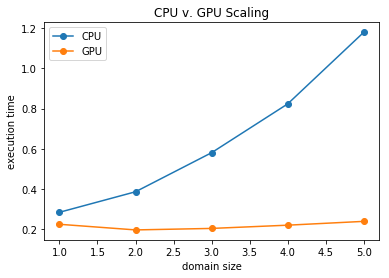

In [44]:
plt.plot(iterations, gtx86_values, "-o", label="CPU")
plt.plot(iterations, gtcuda_values, "-o", label="GPU")


plt.title("CPU v. GPU Scaling")
plt.legend()
plt.xlabel("domain size")
plt.ylabel("execution time")

plt.show()